# Victoria storminess

Has December 2018 been unusually stormy in Victoria? This notebook looks at storminess in Victoria, as measured by windspeed at YYJ, in an attempt to answer that question. I use the "raw" daily historical weather data provided on the ECCC website. To be more rigorous, one would need to use fully homogenized data, to account for sensor drift and station changes, but this gives us a first order estimate. 

Neil Swart, December 2018

In [156]:
import datetime as datetime
import pandas as pd
import re
import glob
import requests
from bs4 import BeautifulSoup
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Utility functions for downloading data
The functions below extract data from the ECCC historical weather website.

In [157]:
def get_year_response(stnid, year):
    """ Get and return an http response for a given station id and year"""
    
    url = 'http://climate.weather.gc.ca/climate_data/bulk_data_e.html?'
    params = {
        'stationID': stnid,
        'format': 'csv',
        'Year': year,
        'Month': 1,
        'Day': 1,
        'timeframe': 2,
         }
    response = requests.get(url, params=params)
    #print response.url
    return response

def loadyr(url):
    """ Load the data for a single year at the given url into a pandas dataframe. Do some processing
    of the columns to give reasonable labels, and also compute a datetime index from the dates and
    set as the index. Finally drop some unwanted columns and the return the dataframe.
    """
    df = pd.read_csv(url, skiprows=24, parse_dates={'Date':[0]})
    df.index = df.Date
    dcol = [ re.sub(r'\(.*?\)', '', col).strip(' ').replace(' ', '_') for col in df.columns ]
    df.columns = dcol
    del_list = [ col for col in dcol if col.split('_')[-1] == 'Flag' ]
    [ del_list.append(v) for v in ['Year', 'Month', 'Day', 'Date'] ]
    df = df.drop(del_list,axis=1)
    return df

def loadall(stnid, startyear='', endyear=''):
    """Load the data contained in path/*.csv into a single pandas dataframe, and return it.
    """
    if startyear == '':
        startyear = 1840
        endyear = datetime.datetime.today().year
        
    for year in range(startyear, endyear + 1):
        response = get_year_response(stnid, year)
        if year == startyear:
            df = loadyr(response.url)
            header = getheader(response)
        else:
            dft = loadyr(response.url)
            df = df.append(dft) 
    return df, header

def getheader(http_response):
    """Load the first 8 lines of file header from an EC weather  data file into a dict and return it
    """
    pdict={}
    it = http_response.iter_lines()
    for k in range(8):
        line = it.next().replace('"','')
        pdict[ line.split(',')[0] ] = line.split(',')[1].strip() 
    return pdict 

def stn_year_range(stationID):
    """
    Takes in the stationID as a string and returns the available years.
    """
    #url = 'http://climate.weather.gc.ca/climateData/dailydata_e.html?timeframe=2&StationID=' + stationID
    url = 'http://climate.weather.gc.ca/climate_data/daily_data_e.html?timeframe=2&StationID=' + stationID
    r = requests.get(url)
    soup = BeautifulSoup(r.content)
    select = soup.find('select', id='Year1')
    try:
        options = [option for option in select.strings]
    except AttributeError:
        print url, select_id, select
        raise
    yl = options[1:]  # The first option is the menu text
    yl = list(set(yl))
    yl.remove('\n')
    yn = np.sort([int(y) for y in yl])
    return yn


## Loading the data into pandas dataframes
The cells below load the data for the Victoria International airport station. This is done is done for two station ids: station 118 covers 1940 to 2013, and was replaced by station 51337 in 2013.

In [158]:
# load the data for station 118 (1940-2013)
stnyrs = stn_year_range('118')
data, pdict = loadall( '118', stnyrs.min(), stnyrs.max() )


In [159]:
# load the data for station 51337 (2013-2018)
stnyrs2 = stn_year_range('51337')
data2, pdict2 = loadall( '51337', stnyrs2.min(), stnyrs2.max() )

In [160]:
# concetenate the two datasets. We assume the gust data is comparable despite the station change. This could be checked
# more explicitly.
joined = pd.concat([data, data2])

In [161]:
# Check that we have the full date range we want
print joined.index.min(), joined.index.max()

1940-01-01 00:00:00 2018-12-31 00:00:00


In [162]:
# Isolate data to only month of December
joined_dec = joined[joined.index.month.isin([12])]

In [163]:
# This converts the "strings" in the dataframe into numbers. It drops missing values (NaNs), including the values it
# cannot convert to a numberic representation, such as "<31" found in the data.
dec_winds = pd.to_numeric(joined_dec['Spd_of_Max_Gust'], errors='coerce').dropna()
dec_winds_2018 = dec_winds[dec_winds.index.year==2018]

## Make some plots of wind gusts

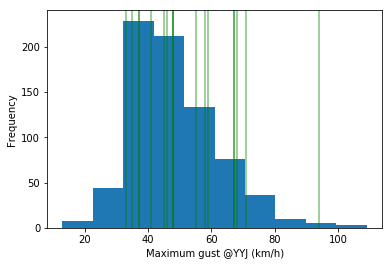

In [164]:
# This figure plots a histogram of maximum gusts, and overlays the 2018 data as vertical green lines.

fig, ax = plt.subplots(1)
dec_winds.hist(ax=ax, grid=False)
for val in dec_winds_2018.values:
    plt.axvline(x=val, color='g', alpha=0.5)

ax.set_xlabel('Maximum gust @YYJ (km/h)')
ax.set_ylabel('Frequency')
fig.savefig('yyj_dec_gust_hist.png', dpi=300)

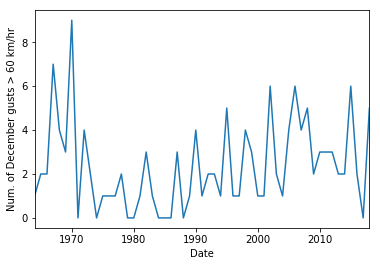

In [165]:
# Here we count the number of gust events which exceed a threshold (60 km/hr) in each year, and 
# plot that number as a function of years.

fig, ax = plt.subplots(1)
(dec_winds > 60).groupby(dec_winds.index.year).sum().plot(ax=ax)
ax.set_ylabel('Num. of December gusts > 60 km/hr')
fig.savefig('yyj_dec_gust_count.png', dpi=300)

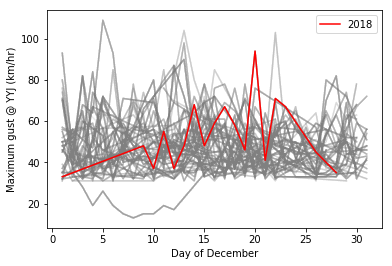

In [166]:
# Here I plot the maximum gust seen in each day of December for all years (grey) and for 2018 (red)

fig, ax = plt.subplots(1)

for y in dec_winds.index.year:
    d=dec_winds[dec_winds.index.year==y]
    plt.plot(d.index.day, d.values, color=[0.5, 0.5, 0.5], alpha=0.05)
    
d=dec_winds[dec_winds.index.year==2018]
plt.plot(d.index.day, d.values, color='r', label='2018')
ax.set_xlabel('Day of December')
ax.set_ylabel('Maximum gust @ YYJ (km/hr)')
ax.legend()
fig.savefig('yyj_dec_gust_by_day.png', dpi=300)

In [167]:
allwinds = pd.to_numeric(joined['Spd_of_Max_Gust'], errors='coerce').dropna()


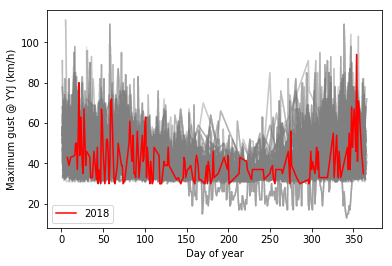

In [168]:
fig, ax = plt.subplots(1)

for y in dec_winds.index.year:
    d=allwinds[allwinds.index.year==y]
    plt.plot(d.index.dayofyear, d.values, color=[0.5, 0.5, 0.5], alpha=0.05)
    
d=allwinds[allwinds.index.year==2018]
plt.plot(d.index.dayofyear, d.values, color='r', label='2018')
ax.set_xlabel('Day of year')
ax.set_ylabel('Maximum gust @ YYJ (km/h)')
ax.legend()
#ax.set_ylim([30, 110])
fig.savefig('yyj_gust_by_doy.png', dpi=300)